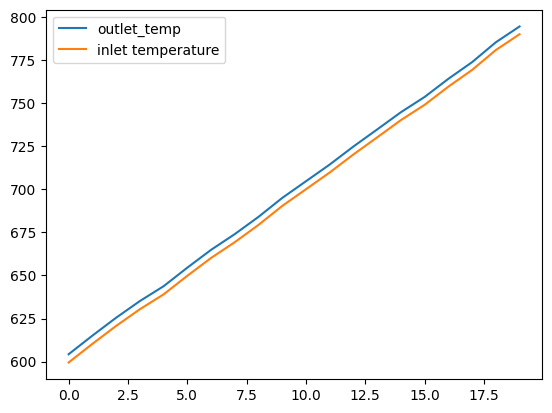

In [50]:
import pyomo.environ as pyo
from idaes.core import FlowsheetBlock
from idaes.models.unit_models import Heater
from idaes.models.properties.general_helmholtz import (
    HelmholtzParameterBlock,
    PhaseType,
    StateVars,
)
from idaes.core.util.model_statistics import degrees_of_freedom
from data import temperature, pressure, power, indexes

m = pyo.ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False,)
m.fs.properties = HelmholtzParameterBlock(
    pure_component="h2o",
    phase_presentation=PhaseType.MIX,
    state_vars=StateVars.TPX,
)
m.fs.heater = Heater(property_package=m.fs.properties)


outlet_temperatures = []
outlet_powers = []


def cost_objective(h):
    return 3**(h.heat_duty[0]/2000)  - (h.outlet.temperature[0]-250) * 30000
m.fs.heater.cost_objective = pyo.Objective(rule=cost_objective, sense=pyo.minimize)

temperature = [temperature[i] + i*10 for i in indexes]

for i in indexes:
    m.fs.heater.inlet.flow_mol[0].fix(100)
    m.fs.heater.inlet.temperature[0].fix(temperature[i])
    m.fs.heater.inlet.vapor_frac[0].fix(1)
    m.fs.heater.inlet.pressure[0].fix(pressure[i])
    #m.fs.heater.heat_duty[0].fix(power[i])
    solver = pyo.SolverFactory("ipopt")
    solver.solve(m)
    
    
    outlet_temperatures.append(m.fs.heater.outlet.temperature[0].value)
    outlet_powers.append(m.fs.heater.heat_duty[0].value)

import matplotlib.pyplot as plt

plt.plot(outlet_temperatures, label="outlet_temp")
plt.plot(temperature, label="inlet temperature")
plt.legend()
